In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import scipy.stats as ss
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets


time_interval = 10 #sec/frame

#get directories and open separated datasets
basedir = 'E:/Aaron/Combined_37C_Confocal_PCA_smooth/'
datadir = basedir + 'Data_and_Figs/'
savedir = basedir + 'Para-Nitro-Blebbistatin/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)


nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)


#limit data to the Para-Nitro-Blebbistatin experiments
TotalFrame = FullFrame[FullFrame.Experiment == 'Drug']
dates = [20240624,20240626,20240701,20241125,20241126,20241127]
TotalFrame = TotalFrame[TotalFrame.Date.isin(dates)]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['DMSO','Para-Nitro-Blebbistatin'], ordered=True)

In [3]:
################# get "n" of the dataset ###########
inn = len(TotalFrame[TotalFrame.Treatment =='DMSO'])
cn = len(TotalFrame[TotalFrame.Treatment =='DMSO'].CellID.unique())
print(f'There are {inn} images of {cn} unique DMSO cells')
inn = len(TotalFrame[TotalFrame.Treatment =='Para-Nitro-Blebbistatin'])
cn = len(TotalFrame[TotalFrame.Treatment =='Para-Nitro-Blebbistatin'].CellID.unique())
print(f'There are {inn} images of {cn} unique Para-Nitro-Blebbistatin cells')

There are 25834 images of 374 unique DMSO cells
There are 24476 images of 331 unique Para-Nitro-Blebbistatin cells


In [4]:
############### get list of metrics that are significant ttest of CELL AVERAGES ############
ModeFrame = TotalFrame.groupby(['Treatment','CellID']).mean().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Date','activity','Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])


for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])        
        if p_val < 0.05:
            siglist.append(c)
            print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')
siglist = sorted(siglist)


Name: Cell_Volume, t-statistic: 2.139510833081583, p value: 0.03274402449463666
Name: Cell_Volume_Front, t-statistic: 2.9640122597143344, p value: 0.003141032183728952
Name: Cell_Volume_Right, t-statistic: 2.081738229380802, p value: 0.03773387597413983
Name: Cell_Volume_Top, t-statistic: 1.9668893210197094, p value: 0.04959570724280662
Name: Cell_SurfaceArea, t-statistic: 2.009813016474665, p value: 0.0448392316709293
Name: speed, t-statistic: 4.892796249812569, p value: 1.2388373546944356e-06
Name: PC3, t-statistic: -2.290196763387186, p value: 0.022310348094983695
Name: PC6, t-statistic: 2.0297402076835995, p value: 0.042765627616788315
Name: PC8, t-statistic: 2.4970121119195716, p value: 0.012756129054255372
Name: PC9, t-statistic: 2.218626067300396, p value: 0.026836379122823984
Name: PC10, t-statistic: 2.7649142399831526, p value: 0.005845649809371881
Name: Volume_Front_Ratio, t-statistic: 2.9612762081795876, p value: 0.0031687151624842243
Name: Cell_UpDownAngle, t-statistic: 2.9

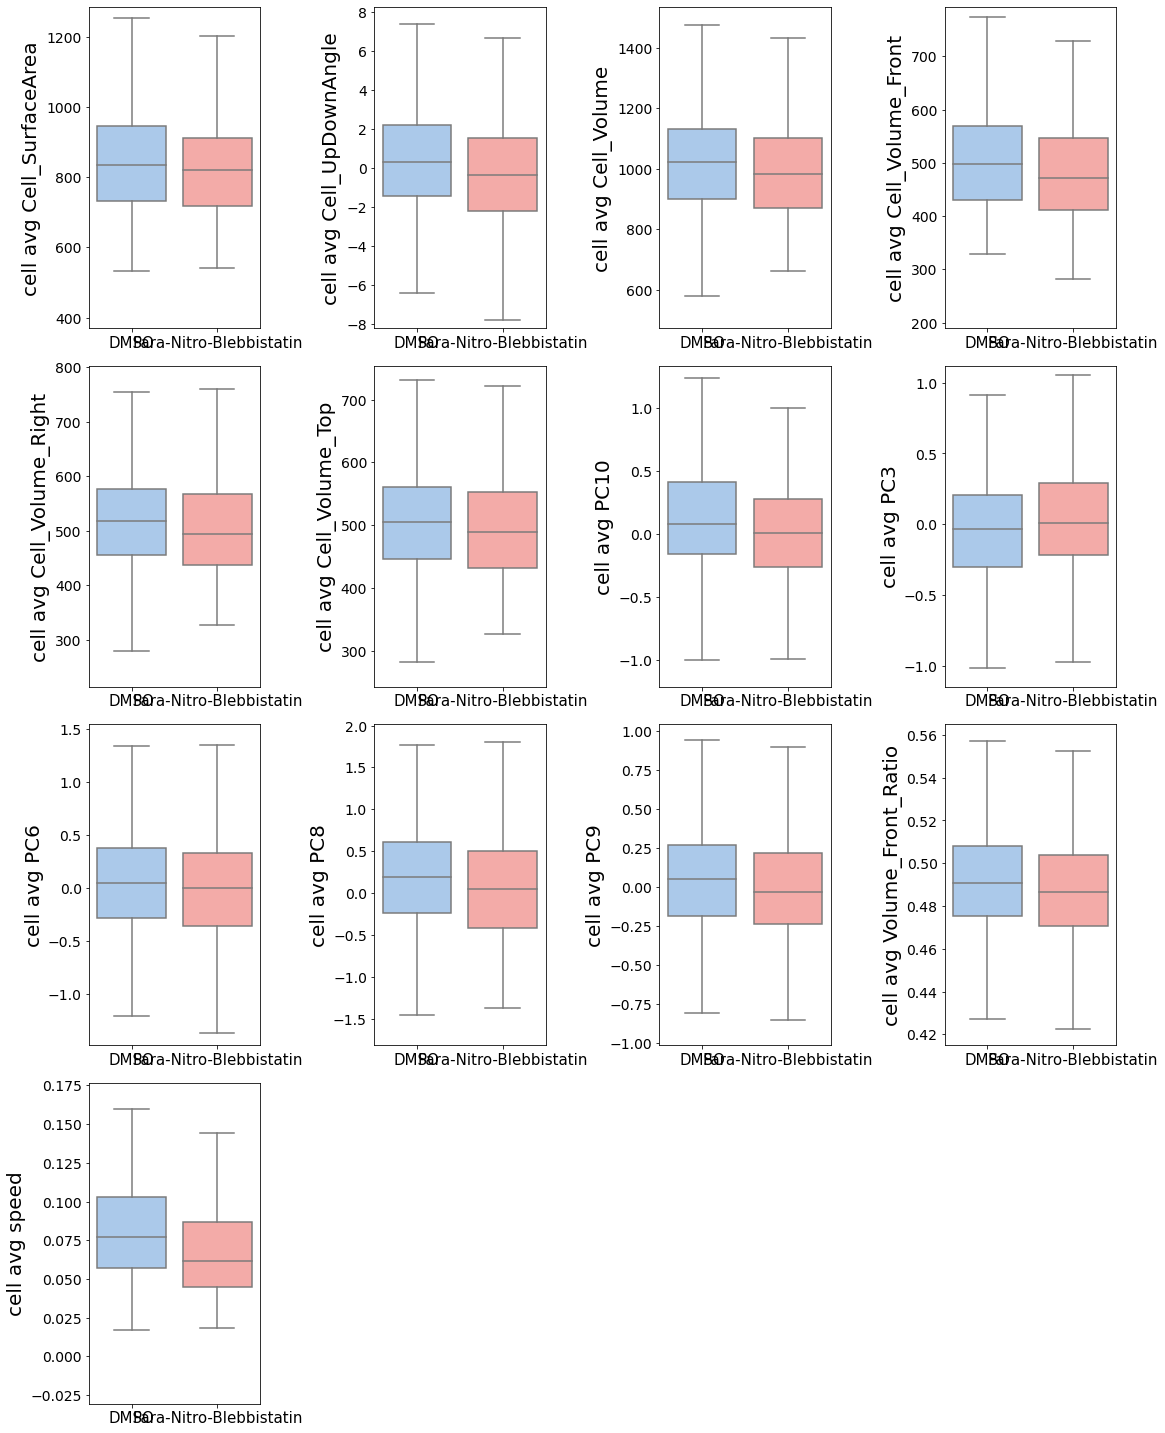

In [5]:
############### CELL AVERAGES OF SIGNIFICANT METRICS #################################
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
sigframe = TotalFrame.groupby(['Treatment','CellID'])
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    mean = sigframe[sig].mean()
    st = sigframe[sig].std()
    tempframe = pd.DataFrame({'avg':mean,'st':st}).reset_index(level='Treatment')
    
#     # Add colorbar
#     norm = plt.Normalize(tempframe['st'].min(), tempframe['st'].max())
#     sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, ax=axli[i])
    
    #plots
#     sns.stripplot(data=tempframe, x='Treatment', y='avg', hue = 'st', palette = 'viridis', ax=axli[i])
    sns.boxplot(data=tempframe, x='Treatment', y='avg', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = tempframe['avg'].quantile(0.25)
    Q3 = tempframe['avg'].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel('cell avg '+sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    #remove legends
    axli[i].legend_ = None

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison average significant metric boxes.png', bbox_inches='tight')



In [5]:
############### get list of metrics that are significant ttest of CELL STDEVS ############
ModeFrame = TotalFrame.groupby(['Treatment','CellID']).std().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'dist','Date','activity','Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])


for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])        
        if p_val < 0.05:
            siglist.append(c)
            print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')
siglist = sorted(siglist)


Name: Cell_Volume, t-statistic: 2.127420621335395, p value: 0.03373610312245835
Name: Cell_Volume_Top, t-statistic: 3.0069276088086485, p value: 0.0027340753312337664
Name: persistence, t-statistic: 2.568669959656286, p value: 0.010419041452559803
Name: speed, t-statistic: 4.420175066473096, p value: 1.1444635816099204e-05
Name: Turn_Angle, t-statistic: 3.411740399495559, p value: 0.0006829865564479
Name: directional_autocorrelation, t-statistic: 2.220719357797471, p value: 0.02669537871345684
Name: PC3, t-statistic: 2.3550542320650187, p value: 0.01879666960785173


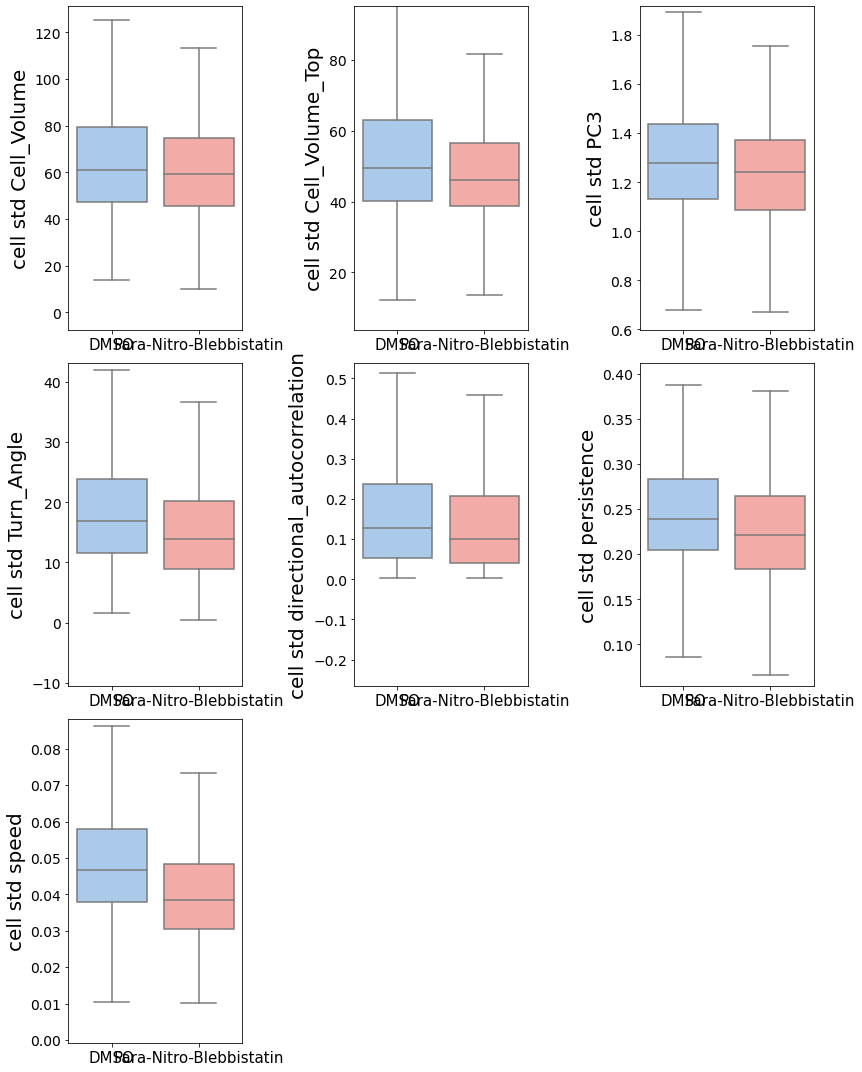

In [6]:
############### CELL AVERAGES OF SIGNIFICANT METRICS #################################
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
sigframe = TotalFrame.groupby(['Treatment','CellID'])
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    mean = sigframe[sig].mean()
    st = sigframe[sig].std()
    tempframe = pd.DataFrame({'avg':mean,'st':st}).reset_index(level='Treatment')
    
#     # Add colorbar
#     norm = plt.Normalize(tempframe['st'].min(), tempframe['st'].max())
#     sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, ax=axli[i])
    
    #plots
#     sns.stripplot(data=tempframe, x='Treatment', y='avg', hue = 'st', palette = 'viridis', ax=axli[i])
    sns.boxplot(data=tempframe, x='Treatment', y='st', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = tempframe['st'].quantile(0.25)
    Q3 = tempframe['st'].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel('cell std '+sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    #remove legends
    axli[i].legend_ = None

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison stdev significant metric boxes.png', bbox_inches='tight')



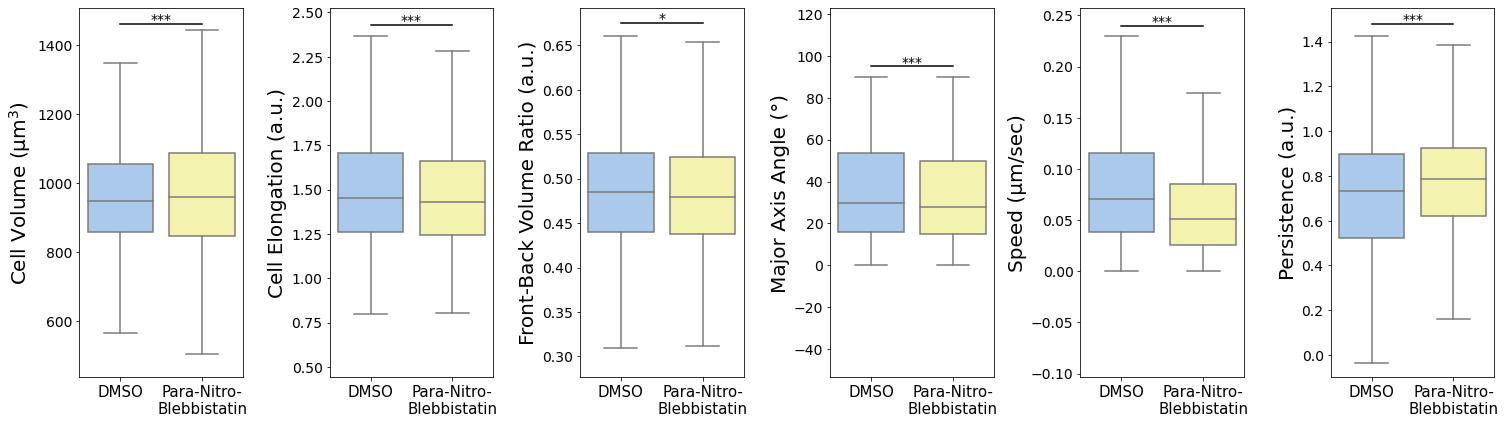

In [19]:
############### Metric distributions by drug #################################
import re


#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,8]]

smallersig = ['Cell_Volume','Cell_Elongation','Volume_Front_Ratio','Cell_TotalAngle',
              'speed','persistence']
siglabels = ['Cell Volume (µm$^3$)', 'Cell Elongation (a.u.)', 'Front-Back Volume Ratio (a.u.)', 'Major Axis Angle (°)',
             'Speed (µm/sec)','Persistence (a.u.)']

sp = math.ceil(math.sqrt(len(smallersig)))
fig, axes = plt.subplots(1, 6, figsize=(3.5*len(smallersig),len(smallersig)))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, palette = colorlist,# width = 0.15, 
            showfliers=False, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = max(TotalFrame.loc[TotalFrame.Treatment == 'DMSO',sig].quantile(0.25),
             TotalFrame.loc[TotalFrame.Treatment == 'Para-Nitro-Blebbistatin', sig].quantile(0.25))
    Q3 = max(TotalFrame.loc[TotalFrame.Treatment == 'DMSO', sig].quantile(0.75),
             TotalFrame.loc[TotalFrame.Treatment == 'Para-Nitro-Blebbistatin', sig].quantile(0.75))
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.85*IQR, Q3 + 1.85*IQR)
    if sig == 'persistence':
        axli[i].set_ylim(-.1, 1.55)
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(['DMSO','Para-Nitro-\nBlebbistatin'], fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
axli[0].axhline(1460,xmin=0.25, xmax = 0.75,color = 'black')
axli[0].text(0.5,1460,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[1].axhline(2.43,xmin=0.25, xmax = 0.75,color = 'black')
axli[1].text(0.5,2.43,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[2].axhline(.675,xmin=0.25, xmax = 0.75,color = 'black')
axli[2].text(0.5,.675,'*',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[3].axhline(95,xmin=0.25, xmax = 0.75,color = 'black')
axli[3].text(0.5,95,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[4].axhline(0.24,xmin=0.25, xmax = 0.75,color = 'black')
axli[4].text(0.5,0.24,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
axli[5].axhline(1.48,xmin=0.25, xmax = 0.75,color = 'black')
axli[5].text(0.5,1.48,'***',fontdict= {'fontsize': 14,
                           'horizontalalignment':'center'})
    
    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison significant metric boxes nice.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


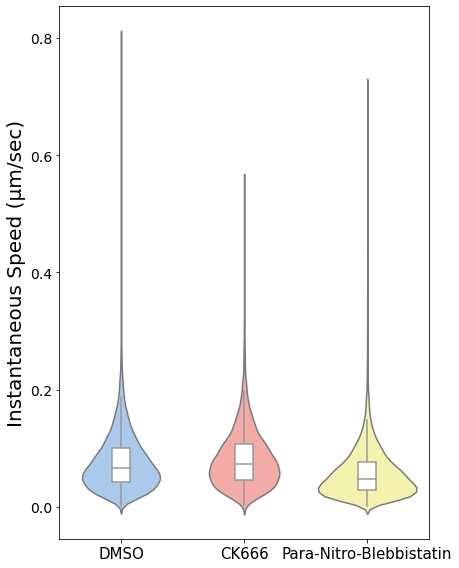

In [7]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = tempframe[tempframe.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['speed']
siglabels = ['Instantaneous Speed (µm/sec)']


fig, ax = plt.subplots(1, 1, figsize=(6.5,8))#, sharex=True)

vp = sns.violinplot(data=tempframe, x='Treatment', y='speed', palette = colorlist, inner = None, ax=ax, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='speed', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=ax)
ax.set_ylabel(siglabels[0], fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels(tempframe.Treatment.unique(), fontsize = 15)#, rotation=45)#, ha = 'right')


plt.tight_layout()
plt.savefig(savedir + 'speed metric violins.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


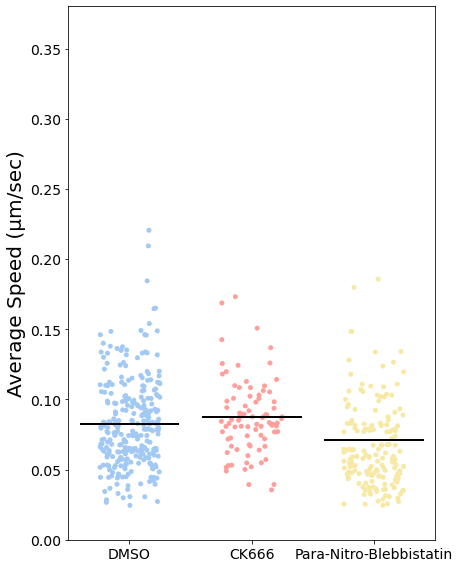

In [8]:
tempframe = TotalFrame[TotalFrame.speed<0.8]
realavg = []
for i, c in tempframe.groupby(['CellID', 'Treatment']):
    realavg.append([i[0], i[1], c.speed.mean()])
newrealavg = pd.DataFrame(realavg, columns = ['CellID','Treatment','Average Speed (µm/sec)'])


colorlist = ['#a1c9f4', '#ff9f9b', '#f7e9a3']

fig, ax = plt.subplots(figsize = (6.5,8))
sns.stripplot(newrealavg['Treatment'],newrealavg['Average Speed (µm/sec)'], jitter = 0.25, palette = colorlist, ax = ax)

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=newrealavg['Treatment'],
            y=newrealavg['Average Speed (µm/sec)'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(),fontsize=20)
ax.set_ylim(0,0.38)
ax.tick_params('x', labelsize=14)
ax.tick_params('y', labelsize=14)


plt.tight_layout()
plt.savefig(savedir + 'average speed metric jitter.png', bbox_inches='tight')

In [129]:
for i,x in TotalFrame.groupby('Treatment'):
    print(i, x.Cell_Elongation.mean())

DMSO 1.4823196268539875
CK666 1.5066161690532378
Para-Nitro-Blebbistatin 1.537569831290352


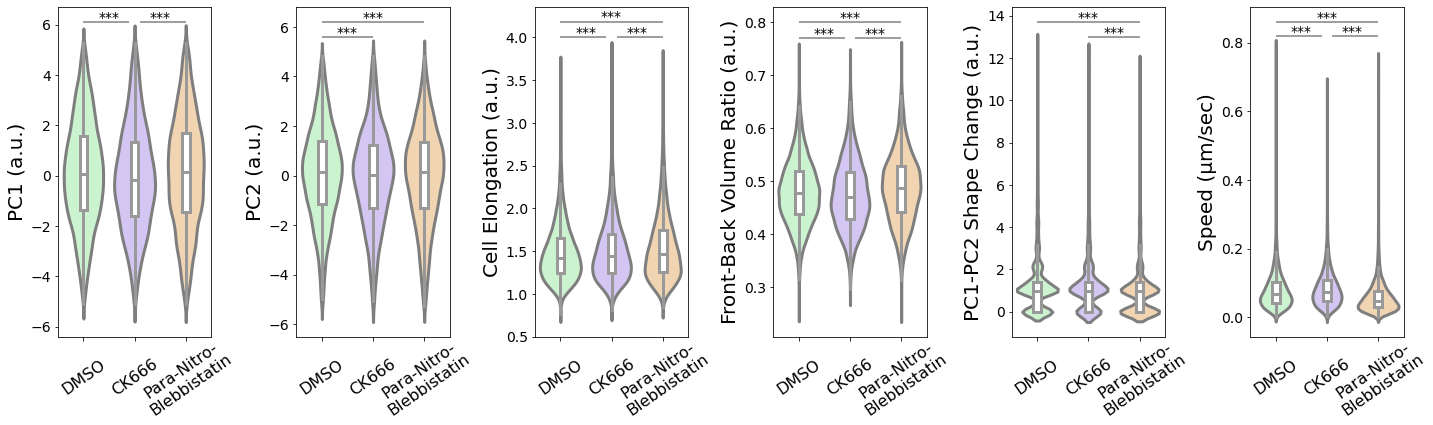

In [138]:
############### Metric distributions by treatment FOR ASCB #################################

import re


#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = tempframe[tempframe.Turn_Angle<30]
# tempframe = tempframe[tempframe.PC1_PC2_distance_to<3]


colorlist = ['#c5fac9','#d0befa','#fcd6a7']

smallersig = ['PC1','PC2','Cell_Elongation','Volume_Front_Ratio','PC1_PC2_distance_to','speed']
siglabels = ['PC1 (a.u.)','PC2 (a.u.)','Cell Elongation (a.u.)','Front-Back Volume Ratio (a.u.)','PC1-PC2 Shape Change (a.u.)','Speed (µm/sec)']



fig, axes = plt.subplots(1, 6, figsize=(20,6))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Migration_Mode'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, linewidth=3, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(['DMSO','CK666','Para-Nitro-\nBlebbistatin'], fontdict= {'fontsize': 16,
                                                                                      'verticalalignment':'center',
                                                                                      'rotation':35,
                                                                                      'y':-.1})

# ax.tick_params('x', labelsize=16, rotation = 35)

axli[0].hlines(6.1, 0, .9, colors='grey', linestyles='solid')
axli[0].text(0.5,6.11,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[0].hlines(6.1, 1.1, 2, colors='grey', linestyles='solid')
axli[0].text(1.5,6.11,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
    
axli[1].hlines(5.6, 0, 1, colors='grey', linestyles='solid')
axli[1].text(0.5,5.61,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[1].hlines(6.2, 0, 2, colors='grey', linestyles='solid')
axli[1].text(1,6.21,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[2].hlines(4, 1.1, 2, colors='grey', linestyles='solid')
axli[2].text(1.5,4.01,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[2].hlines(4.18, 0, 2, colors='grey', linestyles='solid')
axli[2].text(1,4.19,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[2].hlines(4, 0, 0.9, colors='grey', linestyles='solid')
axli[2].text(0.5,4.01,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[3].hlines(.77, 1.1, 2, colors='grey', linestyles='solid')
axli[3].text(1.5,.771,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[3].hlines(.8, 0, 2, colors='grey', linestyles='solid')
axli[3].text(1,.801,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[3].hlines(.77, 0, 0.9, colors='grey', linestyles='solid')
axli[3].text(0.5,.771,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[4].hlines(13, 1, 2, colors='grey', linestyles='solid')
axli[4].text(1.5,13.01,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[4].hlines(13.7, 0, 2, colors='grey', linestyles='solid')
axli[4].text(1,13.71,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

axli[5].hlines(.82, 1.1, 2, colors='grey', linestyles='solid')
axli[5].text(1.5,.821,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[5].hlines(.86, 0, 2, colors='grey', linestyles='solid')
axli[5].text(1,.861,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[5].hlines(.82, 0, 0.9, colors='grey', linestyles='solid')
axli[5].text(0.5,.821,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
    
    
plt.tight_layout()
plt.savefig(savedir + f'treatment metric violins FOR ASCB 2023.png', bbox_inches='tight', dpi = 500)



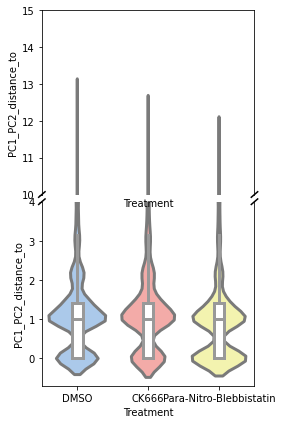

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(4,6))#, sharex=True)

# for m, mig in tempframe.groupby('Migration_Mode'):
divider = make_axes_locatable(ax)
ax2 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax2)

vp = sns.violinplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', palette = colorlist, linewidth=3, inner = None, ax=ax, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', width = 0.15, 
        color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=ax)
ax.set_ylim(-.7, 4)
ax.spines['top'].set_visible(False)
vp = sns.violinplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', palette = colorlist, linewidth=3, inner = None, ax=ax2, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='PC1_PC2_distance_to', width = 0.15, 
        color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=ax2)
ax2.set_ylim(10, 15)
ax2.tick_params(bottom=False, labelbottom=False)
ax2.spines['bottom'].set_visible(False)


# From https://matplotlib.org/examples/pylab_examples/broken_axis.html
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.tight_layout()

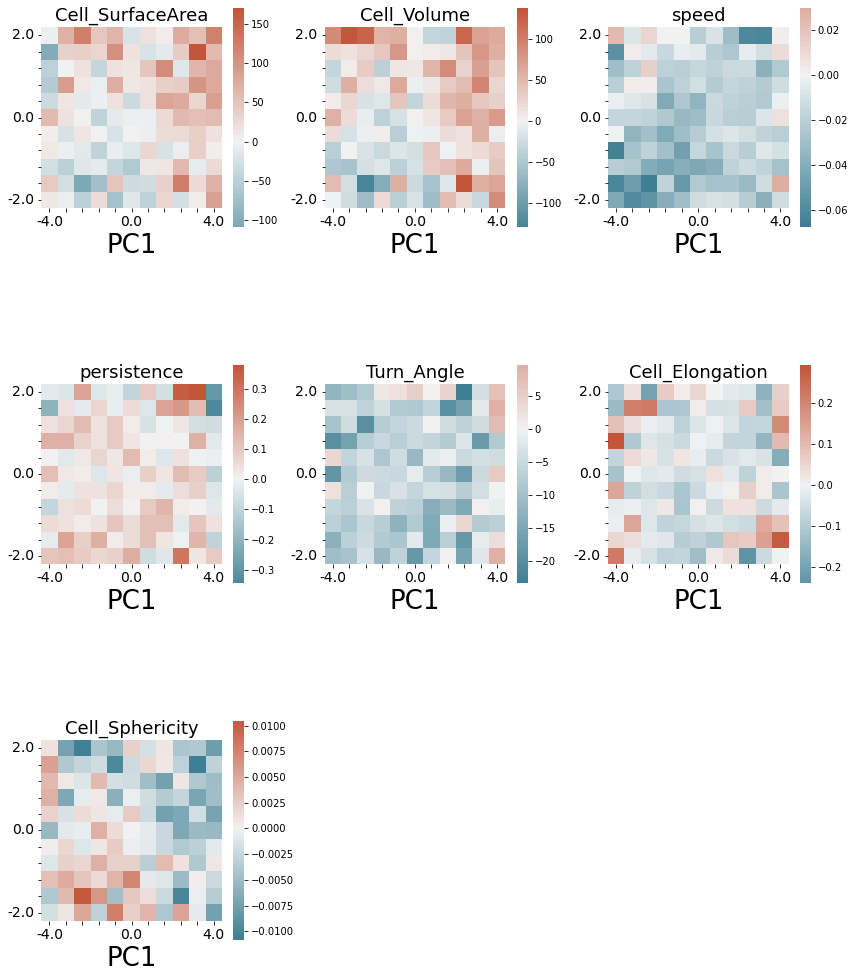

In [53]:
########### PLOT THE DIFFERENCE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle','Cell_Elongation', 'Cell_Sphericity']

sp = math.ceil(math.sqrt(len(metrics)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axf = axes.flatten()
for i, met in enumerate(metrics):
    ax = axf[i]
    ################ heatmap of the given metric #############
    #make numpy array with heatmap data
    bighm = np.zeros((len(TotalFrame.Treatment.unique()),nbins,nbins))
    for n in range(bighm.shape[0]):
        mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
        for x in range(nbins):
            for y in range(nbins):
                current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC7bins'] == y+1)].dropna(subset=[met])
                if current.empty:
                    bighm[n,y,x] = 0
                elif len(current)==1:
                    bighm[n,y,x] = current[met]
                else:
                    bighm[n,y,x] = current[met].mean()

    diffhm = bighm[1,:,:]-bighm[0,:,:]
    #plot heatmap with seaborn
    #### use the max and the lowest non zero as min
    sns.heatmap(
        diffhm,
        #vmin=np.min(bighm[np.nonzero(bighm)]),
        #vmax=np.max(bighm),
        center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar_kws={'shrink': 0.65}
    )
    ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 14
        )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 14
    )
    #take out all axis labels except the desired ones
    for o, l in enumerate(ax.xaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    for o, l in enumerate(ax.yaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)      
    if (a == 0):
        ax.set_ylabel(f'{met}\nPC7', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(met, fontsize = 18)
for a in range(i+1, len(axf)):
    axf[a].remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 difference heatmaps.png', bbox_inches='tight')

In [5]:
from CustomFunctions import linear_cycle_utils

origin = [5, 6]
whichpcs = [1,7]
binrange = 10
direction = 'counterclockwise'

angframe = linear_cycle_utils.linearize_cycle_continuous(
            TotalFrame, 
            centers,
            origin, 
            whichpcs,  
            binrange, 
            direction,)


<AxesSubplot:xlabel='PC1_PC7_Continuous_Angular_Bins', ylabel='cellcount'>

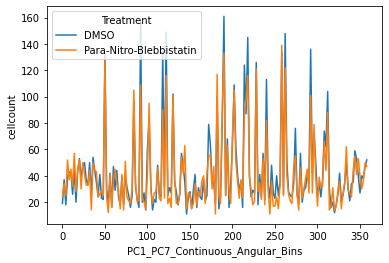

In [41]:
###### count the number of images in the bins around the linear CGPS #######

countdf = pd.DataFrame()
countlist = []
treatmentlist = []
for t in TotalFrame.Treatment.unique():
    binlens = [len(x) for i, x in TotalFrame[TotalFrame.Treatment==t].groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins')]
    countlist.extend(binlens)
    treatmentlist.extend([t]*len(binlens))
# np.array((treatmentlist,list(TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'].unique())*2, countlist)).T
countdf = pd.DataFrame(np.array((treatmentlist,list(TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'].unique())*2, countlist)).T,
                       columns=['Treatment',f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins','cellcount'])
countdf.cellcount = countdf.cellcount.astype(int)
countdf[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'] = countdf[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'].astype(int)
fig, ax = plt.subplots()
sns.lineplot(data = countdf, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = 'cellcount', hue = 'Treatment', ax = ax)

<AxesSubplot:xlabel='PC1_PC7_Continuous_Angular_Coord', ylabel='Count'>

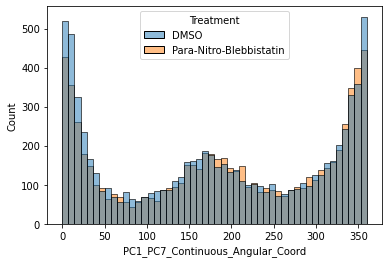

In [35]:
fig, ax = plt.subplots()
sns.histplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord', bins=50, 
                     hue = 'Treatment', ax = ax)

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\

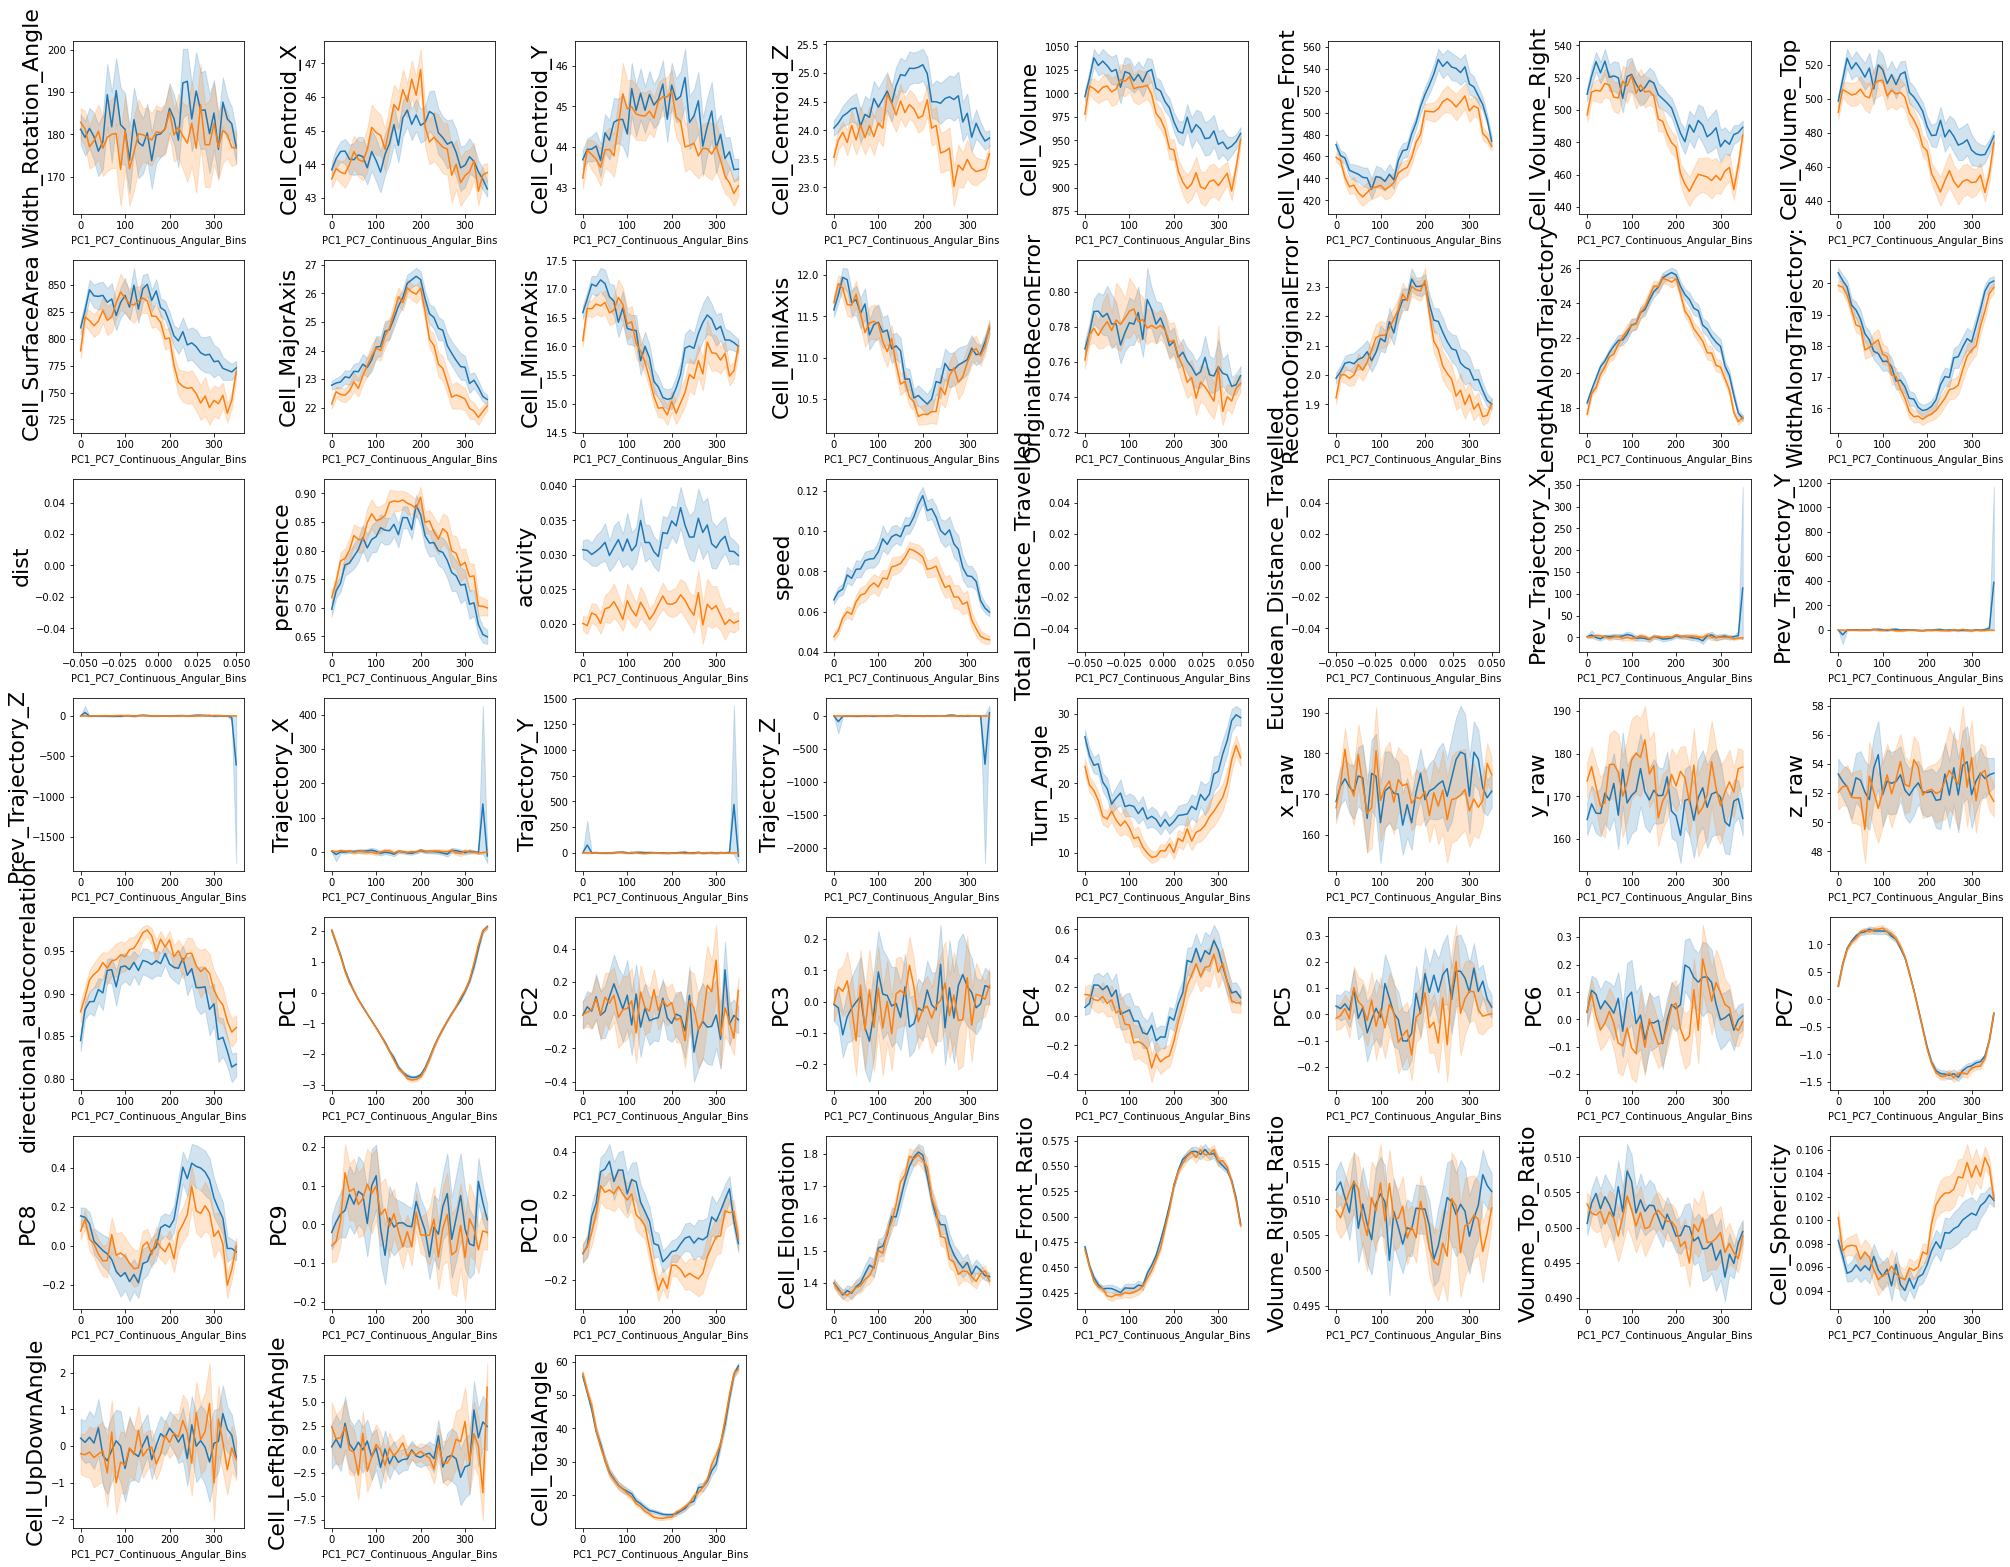

In [6]:
################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in angframe.columns if 'Euler' in x])
removeex.extend([x for x in angframe.columns if 'avg' in x])
removeex.extend([x for x in angframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in angframe.columns if 'intensity' in x])
removeex.extend([x for x in angframe.columns if 'Velocity' in x])
removeex.extend([x for x in angframe.columns if 'Coord' in x])
removeex.extend([x for x in angframe.columns if 'Vec' in x])
removeex.extend([x for x in angframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date'])
newframe = angframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs.png', bbox_inches='tight')

In [17]:
############## bootstrap around the linear cycle for metrics ###################

if os.path.exists(savedir + 'linear CGPS bootstrapped metric.csv'):
    allavgsframe = pd.read_csv(savedir + 'linear CGPS bootstrapped metric.csv', index_col=0)
    print('Opened bootstrap file')
else:    
    
    samplesize = 50
    bsiters = 1000

    ### generate the dataframe with all of the sampled data
    treatlist = []
    celllist = []
    bslist = []
    for t in TotalFrame.Treatment.unique():
        for b in range(bsiters):
            treattemp = TotalFrame[TotalFrame.Treatment == t]
            celllist.extend(random.sample(list(treattemp.CellID.unique()), samplesize))
            treatlist.extend([t]*samplesize)
            bslist.extend([b]*samplesize)

    allbs = pd.DataFrame({'Treatment':treatlist,
                   'bsiter':bslist,
                   'CellID':celllist})


    ### sample linearized dataframe and get averages
    allavgs = []
    for i, bi in allbs.groupby('bsiter'):
        tempangframe = angframe[angframe.CellID.isin(bi.CellID.to_list())]
        for a, ab in tempangframe.groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'):
            ab['bsiter'] = [i]* len(ab)
            abavg = ab.mean()
            for index, value in zip(['cell','CellID','structure','Treatment','Experiment'],
                                   ab[['cell','CellID','structure','Treatment','Experiment']].iloc[0].values):
                abavg[index] = value
            allavgs.append(abavg)

    allavgsframe = pd.DataFrame(allavgs)
    allavgsframe.to_csv(savedir + 'linear CGPS bootstrapped metric.csv')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\

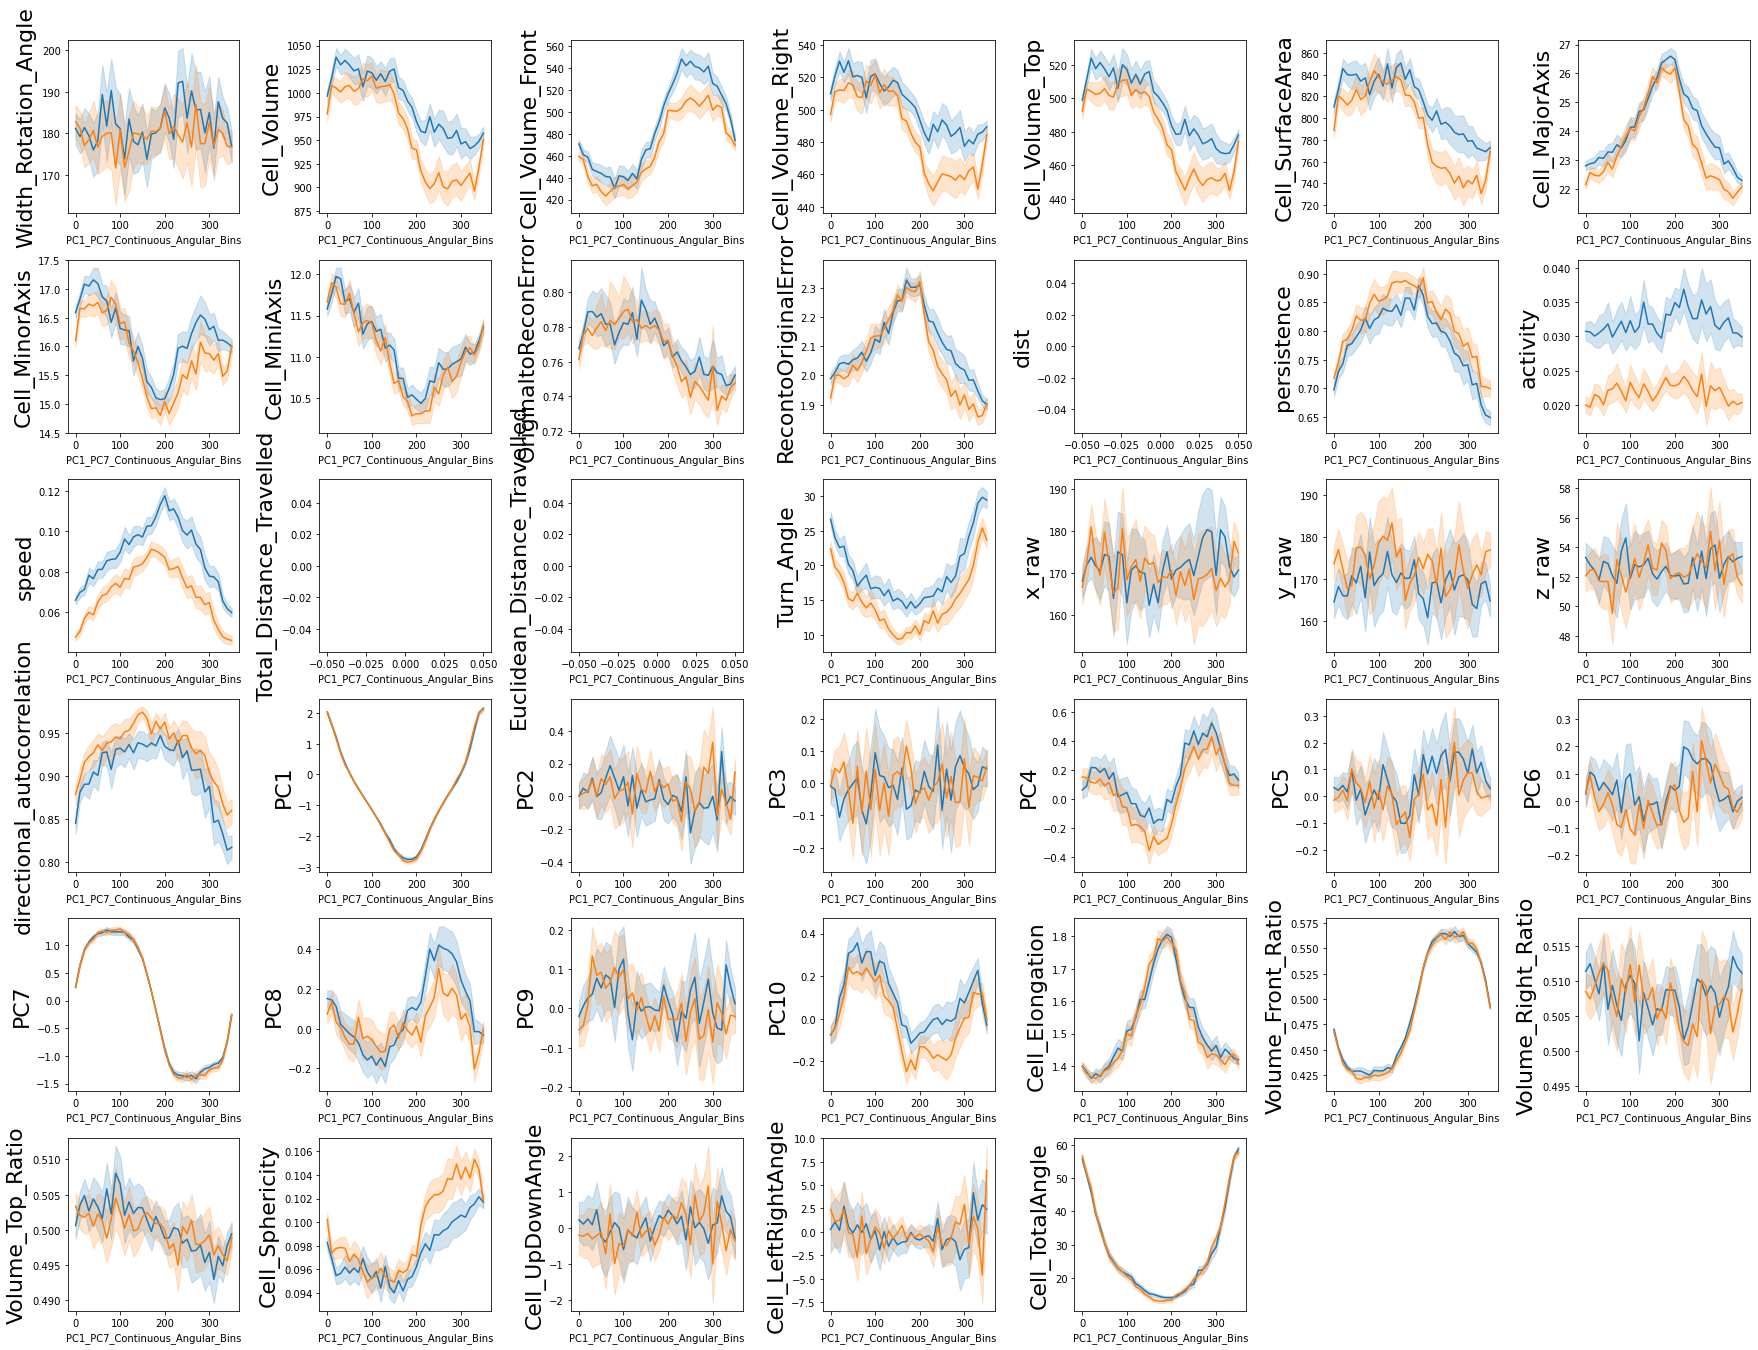

In [18]:


################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in allavgsframe.columns if 'Euler' in x])
removeex.extend([x for x in allavgsframe.columns if 'avg' in x])
removeex.extend([x for x in allavgsframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in allavgsframe.columns if 'intensity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Velocity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Coord' in x])
removeex.extend([x for x in allavgsframe.columns if 'Centroid' in x])
removeex.extend([x for x in allavgsframe.columns if 'Trajectory' in x])
removeex.extend([x for x in allavgsframe.columns if 'Vec' in x])
removeex.extend([x for x in allavgsframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date','bsiter'])
newframe = allavgsframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs with bootstrapping.png', bbox_inches='tight')

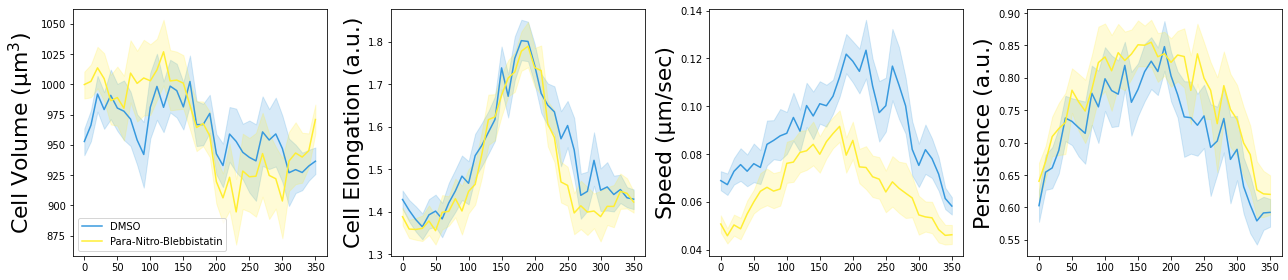

In [13]:


################# LOOK STATS AROUND 1D CYCLE ######################
colorlist = ['#3799de','#ffee33']
metrics = ['Cell_Volume','Cell_Elongation','speed','persistence']
metlabels = ['Cell Volume (µm$^3$)', 'Cell Elongation (a.u.)',
             'Speed (µm/sec)','Persistence (a.u.)']
newframe = allavgsframe[metrics]


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(1, len(metrics), figsize=(4.5*len(metrics),1*len(metrics)))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, palette = colorlist, hue = 'Treatment', ax = ax)
        ax.set_ylabel(metlabels[i])#, fontsize = 1.75*CoRo)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
        ax.set_xlabel('')
        if i!=0:
            ax.legend_ = None
        else:
            ax.legend(loc='lower left')
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} specific Shape Metrics 1D Continuous PCs with bootstrapping.png',
            bbox_inches='tight')

In [31]:
# for t in TotalFrame.Treatment.unique():
#     treattemp = TotalFrame[TotalFrame.Treatment == t]
#     for c in treattemp.CellID.unique():
#         temp = treattemp[treattemp.CellID == c]
#         temp = temp.sort_values('frame').reset_index(drop=True)
#         print(temp)

# # pos = temp.iloc[1:3][['x','y','z']].to_numpy()
# # pos[1:,0] - pos[:-1,0]
runlen = 6
inds = temp.frame.diff()[temp.frame.diff()!=1].index.to_list()
last = 0
for count, u in enumerate(inds[1:]):
    run = temp.iloc[last:int(u)]
    if len(run)<2:
        continue
    elif len(run)>runlen:
        recent = 0
        for r in range(0, len(run), runlen):
            runs.append(run.iloc[recent:r])
            recent = r
        if recent%runlen != 0:
            runs.append(run.iloc[recent:int(recent+recent%runlen)])
    else:
        runs = [run]
    
    for q in runs:
        da = np.full(runlen, np.nan)
        vecs = q[['Trajectory_x','Trajectory_Y','Trajectory_Z']]
        for v in range(1, runlen):
            da[v] = np.sum(vecs[0]/np.linalg.norm(vecs[0]) * vecs[v]/np.linalg.norm(vecs[v]))
    
    last = int(u)

0    NaN
1    1.0
2    1.0
Name: frame, dtype: float64
3   NaN
Name: frame, dtype: float64
4     NaN
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
Name: frame, dtype: float64
25    NaN
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
Name: frame, dtype: float64
36   NaN
Name: frame, dtype: float64
37    NaN
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
Name: frame, dtype: float64
49   NaN
Name: frame, dtype: float64
50    NaN
51    1.0
52    1.0
Name: frame, dtype: float64
53    NaN
54    1.0
55    1.0
56    1.0
57    1.0
58    1.0
59    1.0
60    1.0
Name: frame, dtype: float64
61    NaN
62    1.0
63    1.0
64    1.0
65    1.0
66    1.0
Name: frame, dtype: float64
67    NaN
68    1.0
Name: frame, dtype: float64
69    NaN

In [45]:
one = [2,3,4]
two = [-4, 5, 1]
np.sum(one/np.linalg.norm(one) * two/np.linalg.norm(two))

0.31518754028368906